In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import glob
from tqdm.notebook import tqdm

import geopandas as gpd

from dtw import dtw

import plotly.express as px
import plotly.graph_objects as go

/home/weigangtang/anaconda3/envs/pangeo-220415/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_236819/2603901497.py:10: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Load Data

In [3]:
# target_year = 2022
# df_bts = pd.read_csv(f'../data/{target_year}_vh.csv', index_col=0)
# df_ebd = pd.read_csv(f'../data/{target_year}_tsne2d.csv', index_col=0)
# df_lab = pd.read_csv(f'../data/{target_year}_tsne2d_birch_12c.csv', index_col=0)

# target_year = 2022
# data_folder = '../data/tmp/'
# df_bts = pd.read_csv(data_folder + f'vh_{target_year}_original.csv', index_col=0)
# df_ebd = pd.read_csv(data_folder + f'tsne2d_original_{target_year}_exagg_1.2.csv', index_col=0)
# df_lab = pd.read_csv(data_folder + f'tsne2d_original_{target_year}_lab_hdbscan.csv', index_col=0)

target_year = 2018
data_folder = '../data/tmp2/'
df_bts = pd.read_csv(data_folder + f'vh_original_{target_year}.csv', index_col=0)
df_ebd = pd.read_csv(data_folder + f'tsne2d_original_{target_year}_exagg_24.csv', index_col=0)
df_lab = pd.read_csv(data_folder + f'label_original_{target_year}_hdbscan.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/tmp2/vh_minmax_2018.csv'

## Datapoints and Timeseries with Cluster Labels

new version of plot time series show two more lines: median and medoid

In [61]:
def get_mediod_ts(ts_blk):
    ts_med = np.median(ts_blk, axis=0)
    dmat = ts_blk - ts_med[np.newaxis, :]
    dist = np.mean(dmat**2, axis=1)
    imin = np.argmin(dist)
    return ts_blk[imin, :]

def plot_class_hys(df_ts, ncol=4, lb=None, ub=None):

    labels = df_ts.index.get_level_values(0).unique()
    nclass = df_ts.index.get_level_values(0).nunique()

    nrow = int(nclass / ncol) + 1

    fig = plt.Figure(figsize=[ncol * 4, nrow * 3])
    gs = plt.GridSpec(nrow, ncol)

    colors = plt.cm.get_cmap(cmap).colors

    for i in tqdm(range(nclass)):

        target_label = labels[i]

        ts_blk = df_ts.loc[target_label].values
        ts_avg = np.mean(ts_blk, axis=0)

        ax = fig.add_subplot(gs[i])
        ax.plot(ts_blk.T, color=colors[i], alpha=0.2, lw=0.5)
        ax.plot(ts_avg, color='k', lw=1.2)
        ax.set_title(target_label + ' ({})'.format(ts_blk.shape[0]))
        
        ts_med = np.median(ts_blk, axis=0)
        ts_mdd = get_mediod_ts(ts_blk)
        ax.plot(ts_med, color='grey', lw=1.2)
        ax.plot(ts_mdd, color='white', lw=1.2)

        if lb:
            hys_lb = np.percentile(ts_blk, lb, axis=0)
            ax.plot(hys_lb, color='k', lw=.8, ls='--')
        if ub:
            hys_ub = np.percentile(ts_blk, ub, axis=0)
            ax.plot(hys_ub, color='k', lw=.8, ls='--')

    fig.tight_layout()
    fig.patch.set_facecolor('white')
    return fig

k = df_lab['Label'].nunique()
cmap = 'tab10' if k < 10 else 'tab20'

In [62]:
def sort_real_classnumer(df):
    df['Code'] = [
        int(x.split(' ')[1]) 
        if x.startswith('Class') else -1
        for x in df['Label']
    ]
    df = df.sort_values('Code')
    df = df.drop('Code', axis=1)
    return df
    
df_pt = df_ebd.join(df_lab['Label'])
df_pt = sort_real_classnumer(df_pt)

df_ts = df_bts.join(df_lab['Label'])
df_ts = sort_real_classnumer(df_ts)
df_ts = df_ts.set_index('Label', append=True)
df_ts.index = df_ts.index.reorder_levels(order=[1, 0])

  0%|          | 0/14 [00:00<?, ?it/s]

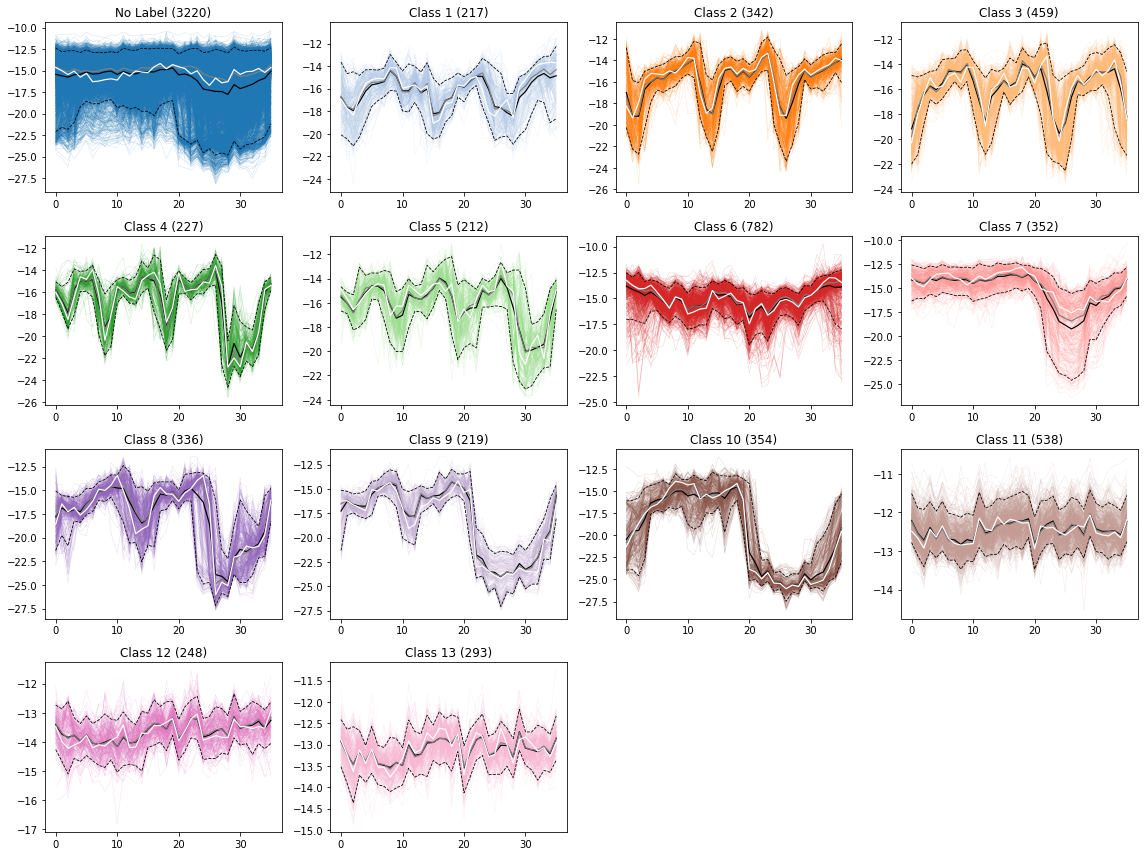

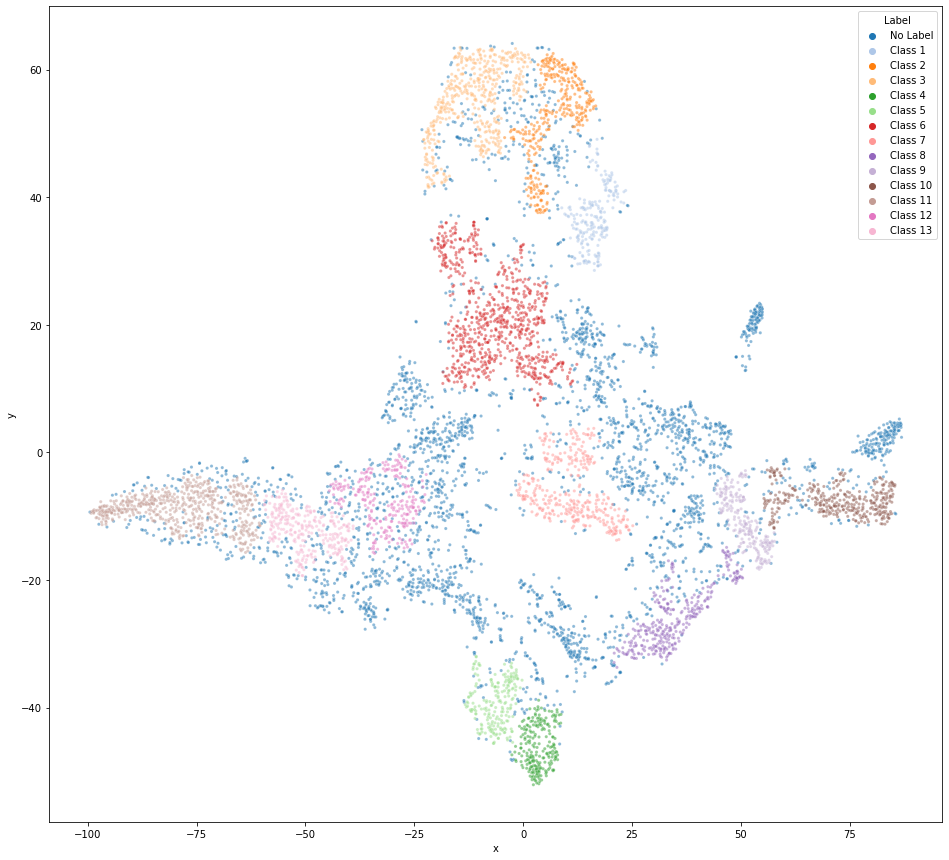

In [63]:
sns.scatterplot(data=df_pt, x='x', y='y', hue='Label', alpha=0.5, s=10, palette=cmap)
plt.gcf().set_size_inches([16, 15])

plot_class_hys(df_ts, lb=5, ub=95)

## Normalize Time Series (Optional)

- use min-max normalization

In [64]:
# mat = df_ts.values
# vmin = np.min(mat, axis=1)[:, np.newaxis]
# vrng = np.max(mat, axis=1)[:, np.newaxis] - vmin

# df_ts = df_ts.copy()
# df_ts.iloc[:, :] = (mat - vmin) / vrng

## Insert Time Steps

add more control points will help DWT window

In [65]:
# insert points between actual data and interpolate
def interpolate_ts(ts_blk, intv=3):

    nrow, ncol = ts_blk.shape
    mat = np.zeros([nrow, ncol * intv]) * np.nan
    mat[:, ::intv] = ts_blk

    df_tmp = pd.DataFrame(mat)
    df_tmp.interpolate(method='linear', axis=1, inplace=True)
    ts_blk_intp = df_tmp.values[:, :-(intv-1)]
    return ts_blk_intp 

data = interpolate_ts(df_ts.values, intv=3)
df_ts = pd.DataFrame(data, index=df_ts.index)
df_ts.shape

(7799, 106)

# Dynamic Time Warping

- Distance of DWT is subject to magnitude of values in time series, so **normalization** may needed
- fastdtw is slower than dtw

In [66]:
def calculate_dtw(ts_blk, ts_ref, window_size=5):
    n = ts_blk.shape[0]
    d = np.zeros(n) * np.nan
    for i in range(n):
        alignment = dtw(
            ts_ref,
            ts_blk[i, :], 
            keep_internals=True,
            window_type= "sakoechiba",
            window_args= {"window_size": window_size},
        )
        d[i] = alignment.distance
    return d

In [68]:
ts_blk = df_ts.values
n = ts_blk.shape[0]

ts_blk_2 = df_ts.loc['Class 5'].values
ts_avg = np.mean(ts_blk_2, axis=0)
ts_med = np.median(ts_blk_2, axis=0)
ts_mdd = get_mediod_ts(ts_blk_2)
ts_ref = ts_med

Cutoff Threshold: 100
Label
Class 1       1
Class 3       2
Class 4     120
Class 5     185
Class 6       2
Class 7       1
No Label     73
Name: 0, dtype: int64


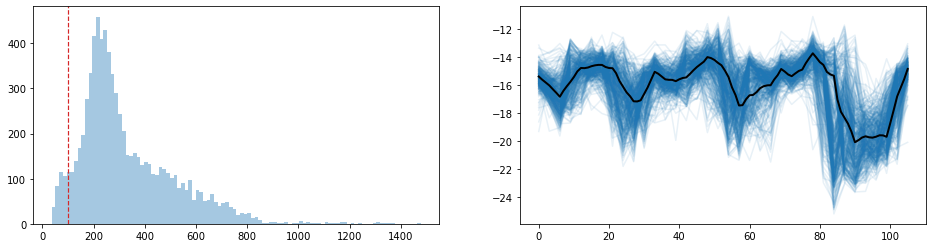

In [69]:
d = calculate_dtw(ts_blk, ts_ref, 7)

# idx = d.argsort()[:600]
# thr = d[idx[-1]]
thr = 100
idx = d < thr
df_ts_sel = df_ts.iloc[idx, :]

fig, axes = plt.subplots(1, 2, figsize=[16, 4])

axes[0].hist(d, bins=100, alpha=.4);
axes[0].axvline(thr, color='tab:red', linestyle='--', lw=1.2);

axes[1].plot(df_ts_sel.values.T, color='tab:blue', alpha=0.1);
axes[1].plot(ts_ref, color='k', lw=2);

print(f'Cutoff Threshold: {thr}')
print(df_ts_sel.groupby('Label').count().iloc[:, 0])

In [70]:
name = 'rice-lotus'
for thr in range(80, 181, 10):
    idx = d < thr
    df_ts_sel = df_ts.iloc[idx, :]
    df_sel_pid = df_ts_sel.index.get_level_values(1).to_frame()
    df_sel_pid.index = np.arange(df_sel_pid.shape[0]) + 1
    df_sel_pid.to_csv(data_folder + f'sel_pid_{name}_{target_year}_thr_{thr:03d}.csv')